# Performance-Metriken

In den letzten Teilen hast du Dimensionsreduktion, Clustering und Topic-Modelle kennengelernt. All diese unüberwachten Methoden haben Parameter, die du optimieren kannst. Doch welche Variante funktioniert am besten? Um das beurteilen zu können, benötigst du *Metriken*, die du optimieren kannst.

Im Fall der Dimensionsreduktion ist das (scheinbar) ziemlich einfach. Du kannst die Transformation einfach wieder rückwärts durchführen und die Abweichungen bestimmen. Dieser sog. *quadratische Fehler* wird häufig dazu verwendet. Allerdings ist das nicht immer sinnvoll, denn ab und zu wirst du andere Kriterien benötigen, z.B. das "ähnliche" Vektoren möglichst zusammengefasst werden. t-SNE kann keine Rücktransformationen durchführen - bei UMAP geht das eingeschränkt.

Etwas einfacher sieht es bei Clustering aus, da gibt es das sog. *Silhouette-Maß*. Das kannst du besonders auf *konvexe Cluster* anwenden. Außerdem gibt es noch den *Calinski-Harabasz-Score*.

Bei Topic-Modellen kannst du die *Perplexität* benutzen. Das Maß drückt aus, wie gut ein bisher unbekanntes Dokument sich in die Topic-Struktur eingliedert. Leider entspricht das Maß nicht der menschlichen Intuition, deswegen wirst du dich hier auch auf die *Kohärenz* der Topics konzentrieren. Die misst, wie gut die Wörter eines Topics zusammenpassen.

## Dimensionsreduktion

Unsere Experimente nutzen wie gehabt das Digit-Datenset:

In [1]:
from sklearn import datasets
digits = datasets.load_digits()

Du kannst nun eine PCA in zwei Dimensionen durchführen und den mittleren quadratischen Fehler selbst bestimmen:

In [2]:
import numpy as np
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
data2 = pca2.fit_transform(digits["data"])
data_inverse = pca2.inverse_transform(data2)
np.square(digits["data"] - data_inverse).sum() / len(digits["data"])

858.9447808488462

Sicher fällt der Fehler mit zunehmender Anzahl an Dimensionen. Das kannst du einfach verifizieren:

In [3]:
err = []
for n in range(2, 65):
    pca_n = PCA(n_components=n)
    data_n = pca_n.fit_transform(digits["data"])
    data_inverse_n = pca_n.inverse_transform(data_n)
    err.append((n, np.square(digits["data"] - data_inverse_n).sum() / len(digits["data"])))

<AxesSubplot:xlabel='n'>

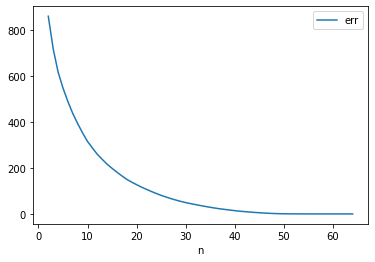

In [4]:
import pandas as pd
pd.DataFrame(err, columns=["n", "err"]).set_index("n").plot()

Bei t-SNE kannst du die *Kullback-Leibler-Divergenz* als Maß verwenden. Sie zeigt die, wie stark sich die Verteilungen in dem ursprünglichen und transformierten Raum unterscheiden. Je näher sie an `0` liegt, desto besser.

In [5]:
from sklearn.manifold import TSNE
tsne2 = TSNE(n_components=2, random_state=42)
tdata2 = tsne2.fit_transform(digits["data"])
tsne2.kl_divergence_

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.7437670826911926

UMAP unterstützt wiederum die Rücktransformation:

In [6]:
import umap
umap2 = umap.UMAP(n_components=2, random_state=42)
udata2 = umap2.fit_transform(digits["data"])
udata_inverse = umap2.inverse_transform(udata2)
np.square(digits["data"] - udata_inverse).sum() / len(digits["data"])

472.9444062850044

Wie erwartet ist das Ergebnis besser als das von PCA in zwei Dimensionen.

## Clustering

In [7]:
from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=5, random_state=42).fit(digits["data"])
km10 = KMeans(n_clusters=10, random_state=42).fit(digits["data"])

Der Silhouette-Score ist idealerweise `1`, `0` bedeutet Überlappungen.
Calinski-Harabasz ist größer, je besser die Cluster separiert sind.

Probiere die Scores mit zwei unterschiedlichen Cluster-Konfigurationen aus, die jeweils mit K-Means berechnet werden:

In [8]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
print(silhouette_score(digits["data"], km5.labels_))
print(silhouette_score(digits["data"], km10.labels_))
print(calinski_harabasz_score(digits["data"], km5.labels_))
print(calinski_harabasz_score(digits["data"], km10.labels_))

0.13819960064433023
0.18244258012780126
197.81559602873295
169.19222276650544


Die Birch-Cluster waren zuletzt besser, wird das auch in den Metriken abgebildet?

In [9]:
from sklearn.cluster import Birch
birch5 = Birch(n_clusters=5).fit(digits["data"])
birch10 = Birch(n_clusters=10).fit(digits["data"])

print(silhouette_score(digits["data"], birch5.labels_))
print(silhouette_score(digits["data"], birch10.labels_))
print(calinski_harabasz_score(digits["data"], birch5.labels_))
print(calinski_harabasz_score(digits["data"], birch10.labels_))

0.11888125787404626
0.17849659940596496
174.1087127387379
161.20475281721804


Der Score sieht tatsächlich bei Birch schlechter aus, auch wenn die Ergebnisse eher den echten Zahlen entsprechen. Das liegt möglicherweise daran, dass die echten Ergebnisse gar nicht konvex im Raum verteilt sind.

## Topic-Modelle

Hier berechnest du wieder die gewohnten Topic-Modelle:

In [10]:
from sklearn import datasets
news = datasets.fetch_20newsgroups()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
STOPWORDS = {'none', 'thereby', 'mine', 'serious', 'whereafter', 'nothing', "'ll", 
             'itself', 'first', 'whoever', '’ve', 'noone', 'moreover', 'regarding', 
             'but', 'various', 'and', 'their', 'between', 'everyone', 'us', 'other', 
             'third', 'last', 'only', 'been', 'always', 'throughout', 'over', 'anyhow', 
             'i', 'nobody', 'be', 'off', "'d", 'then', 'eleven', 'since', "'ve", 'did', 
             'ever', 'than', 'call', 'few', 'could', 'whatever', 'front', 'there', 
             'across', 'whenever', 'is', 'this', 'empty', 'indeed', 'please', 'namely', 
             'his', 'eight', 'those', 'hence', 'wherein', 'amongst', 'using', 'both', 
             '’re', 'seem', 'two', 'several', 'whether', 'about', 'due', 'behind', 'am', 
             'what', 'name', 'has', 'three', 'therefore', '‘s', 'whereas', 'the', 'until', 
             'meanwhile', 'anything', 'that', 'never', 'how', 'sometimes', 'each', 
             'toward', 'doing', 'someone', 'at', 'hereafter', 'almost', 'if', 'same', 
             'her', 'anyone', 'became', 'into', 'latter', 'by', "'s", 'four', 'wherever', 
             'besides', 'must', 'thence', 'in', 'anywhere', 'any', 'twelve', 'out', 'it', 
             'one', 'least', 'used', '‘ll', 'put', 'therein', 'a', 're', 'she', 'are', 
             'beforehand', 'my', 'through', 'ten', 'go', 'too', '’m', 'either', 'below', 
             'else', 'around', 'all', 'except', 'n‘t', 'not', 'such', '‘re', 'was', '’s', 
             'may', 'whence', 'also', 'another', 'beyond', 'without', 'perhaps', 'alone', 
             'should', 'nevertheless', 'own', 'he', 'these', 'seemed', 'give', 'made', 
             'some', 'part', 'on', 'himself', 'hereupon', 'whereupon', 'six', 'via', 'of', 
             'quite', "'m", 'however', 'onto', 'as', 'sometime', 'more', 'while', 'sixty', 
             'does', 'everywhere', 'elsewhere', 'whither', 'who', 'nor', 'seeming', 
             'formerly', 'nowhere', 'our', 'former', 'hereby', 'further', "'re", 
             'can', 'thus', 'something', 'why', 'themselves', 'were', 'amount', 'do', 
             'we', 'beside', 'mostly', 'they', 'very', 'your', 'somewhere', 'upon', 'so', 
             'them', 'latterly', 'neither', 'within', 'enough', 'hers', 'cannot', 'you', 
             'every', 'most', 'ca', 'show', 'will', 'being', 'after', 'though', 'fifteen', 
             'down', 'really', 'although', 'full', 'up', 'well', 'somehow', 'yourself', 'me', 
             'bottom', 'next', 'many', 'unless', 'or', 'anyway', 'five', 'for', 'say', 
             'twenty', 'would', 'otherwise', 'nine', 'no', 'against', 'ourselves', 'just', 
             'even', 'yet', 'above', '‘d', 'again', 'already', 'others', 'before', 'forty', 
             'here', 'move', '‘m', "n't", 'with', 'now', 'seems', 'n’t', 'among', 'which', 
             'towards', 'side', 'still', 'might', 'together', '’ll', 'from', 'everything', 
             'have', 'becoming', 'keep', 'become', 'often', 'herein', 'under', 'whereby', 
             'top', 'thru', 'becomes', 'where', 'along', 'during', 'whole', 'him', 'once', 
             'to', 'afterwards', 'back', 'its', 'get', 'rather', 'because', 'hundred', 
             'make', 'see', 'thereafter', 'done', 'thereupon', 'had', '‘ve', 'ours', 
             'yours', 'much', 'an', 'per', 'whose', 'fifty', 'myself', 'take', 'less', 
             'whom', 'yourselves', 'when', 'herself', '’d',
             'edu', 'university', 'article', 'writes', 'posting', 'nntp', 'host', 
             'organization', 'subject', 'state', 'com', 'netcom', 'uk', 'ac', 'cs', 
             'caltech', 'gov', 'jpl' }

Je nach Topic-Modell musst du unterschiedliche vektorisieren. Für das erste Verfahren, die nicht-negative Matrixfaktorisierung, solltest du TF/IDF verwenden:

In [12]:
tfidf = TfidfVectorizer(stop_words = STOPWORDS, min_df=5)
vec = tfidf.fit_transform(news["data"])

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Für die Berechnung der Kohärenz benötigst du entweder `gensim`, ein komplett anderes Paket für Topic-Modelle oder `tmtoolkit`, das diese Größen auch für die Modelle von `scikit-learn` berechnen kann:

In [ ]:
#!pip install tmtoolkit

### NMF

Du importierst die Methode zur Berechnung der *Coherence-Scores*.

In [13]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np

Die Ergebnisse der Modelle möchtest du dir auch wieder anzeigen.

In [14]:
def display_topics(model, feature_names, no_top_words):
    # wie oben, nur als Text
    for topic_idx, topic in enumerate(model.components_):
        first_index = topic.argsort()[-1]
        print("Topic %s (%02d):" % (feature_names[first_index], topic_idx))
        print(" ".join(["'"+feature_names[i]+"'"
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

Du beginnst mit dem normalen Modell mit 10 Topics und lässt es nochmal anzeigen:

In [15]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=10, random_state=42)
nmf.fit(vec)
display_topics(nmf, tfidf.get_feature_names(), 10)

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic windows (00):
'windows' 'window' 'file' 'dos' 'thanks' 'card' 'use' 'files' 'program' 'graphics'
Topic god (01):
'god' 'jesus' 'bible' 'people' 'christian' 'christians' 'believe' 'faith' 'christ' 'church'
Topic key (02):
'key' 'clipper' 'encryption' 'chip' 'keys' 'escrow' 'government' 'security' 'algorithm' 'crypto'
Topic don (03):
'don' 'year' 'team' 'game' 'like' 'car' 'good' 'think' 'people' 'lines'
Topic pitt (04):
'pitt' 'geb' 'gordon' 'banks' 'cadre' 'dsl' 'n3jxp' 'chastity' 'shameful' 'skepticism'
Topic armenian (05):
'armenian' 'turkish' 'armenians' 'armenia' 'argic' 'serdar' 'turks' 'turkey' 'genocide' 'zuma'
Topic scsi (06):
'scsi' 'drive' 'ide' 'controller' 'drives' 'hard' 'disk' 'bus' 'mac' 'floppy'
Topic nasa (07):
'nasa' 'space' 'henry' 'access' 'digex' 'alaska' 'toronto' 'pat' 'moon' 'zoo'
Topic keith (08):
'keith' 'sgi' 'livesey' 'morality' 'wpd' 'solntze' 'objective' 'jon' 'moral' 'schneider'
Topic israel (09):
'israel' 'israeli' 'jews' 'cleveland' 'arab' 'freene

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Jetzt berechnest du den Coherence-Score für die einzelnen Topics. `c_v` ist eine Art der Berechnung, die Werte sollen sich dabei möglichst nah an `1` bewegen. Lass dir zusätzlich den Mittelwert ausgeben:

In [16]:
res = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=nmf.components_, 
                        dtm=vec, 
                        vocab=np.array(tfidf.get_feature_names()), 
                        texts=tfidf.inverse_transform(vec))
res, sum(res)/len(res)

([0.5176048917721316,
  0.6332535294249947,
  0.7335393560600757,
  0.43181931995049255,
  0.8871373422295633,
  0.7322325875337413,
  0.795919206927657,
  0.5827339650268999,
  0.8151488840191593,
  0.7165989741604701],
 0.6845988057105186)

In einer Schleife kannst du die Coherence-Werte für unterschiedliche Anzahlen von Topics berechnen:

In [17]:
from tqdm.auto import trange
texts = tfidf.inverse_transform(vec)
coh = []
for n in trange(5, 21):
    nmf = NMF(n_components=n, random_state=42)
    nmf.fit(vec)
    res = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=nmf.components_, 
                        dtm=vec, 
                        vocab=np.array(tfidf.get_feature_names()), 
                        texts=texts)
    coh.append((n, sum(res)/len(res)))

  0%|          | 0/16 [00:00<?, ?it/s]

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function

Visualisiere das Ergebnis und suche den optimale Wert heraus:

<AxesSubplot:xlabel='n'>

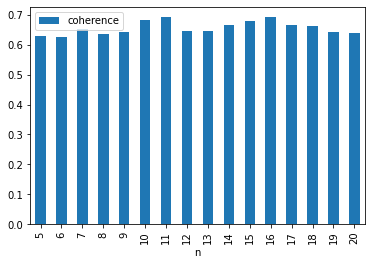

In [18]:
import pandas as pd
pd.DataFrame(coh, columns=["n", "coherence"]).set_index("n").plot.bar()

11 Topics scheinen eine bessere Kohärenz zu haben:

In [19]:
nmf = NMF(n_components=11, random_state=42)
nmf.fit(vec)
display_topics(nmf, tfidf.get_feature_names(), 10)

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic windows (00):
'windows' 'window' 'file' 'dos' 'thanks' 'card' 'files' 'lines' 'use' 'program'
Topic god (01):
'god' 'jesus' 'bible' 'christian' 'christians' 'faith' 'believe' 'christ' 'people' 'church'
Topic key (02):
'key' 'clipper' 'encryption' 'chip' 'escrow' 'keys' 'government' 'algorithm' 'security' 'crypto'
Topic team (03):
'team' 'game' 'hockey' 'games' 'players' 'year' 'season' 'play' 'nhl' 'win'
Topic pitt (04):
'pitt' 'geb' 'gordon' 'banks' 'cadre' 'dsl' 'n3jxp' 'chastity' 'shameful' 'skepticism'
Topic armenian (05):
'armenian' 'turkish' 'armenians' 'armenia' 'argic' 'serdar' 'turks' 'genocide' 'turkey' 'zuma'
Topic scsi (06):
'scsi' 'drive' 'ide' 'controller' 'drives' 'hard' 'disk' 'bus' 'mac' 'floppy'
Topic nasa (07):
'nasa' 'space' 'henry' 'access' 'digex' 'toronto' 'alaska' 'pat' 'moon' 'zoo'
Topic people (08):
'people' 'don' 'gun' 'car' 'like' 'think' 'good' 'know' 'right' 'time'
Topic israel (09):
'israel' 'israeli' 'jews' 'cleveland' 'arab' 'freenet' 'cwru' 'arab

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## LDA

Das gleiche Verfahren führst du nun für LDA durch:

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
cv = TfidfVectorizer(stop_words = STOPWORDS, use_idf=False)
cvec = cv.fit_transform(news["data"])

/home/cwinkler/.venv/jupyter-new/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Der Aufruf ist identisch zu NMF, allerdings ist die Rechenzeit deutlich länger.:

In [22]:
texts = cv.inverse_transform(cvec)
tcoh = []
for n in trange(5, 20):
    lda = LatentDirichletAllocation(n_components=n, random_state=42)
    lda.fit(cvec)
    res = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=cvec, 
                        vocab=np.array(cv.get_feature_names()), 
                        texts=texts)
    tcoh.append((n, sum(res)/len(res)))

  0%|          | 0/15 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n'>

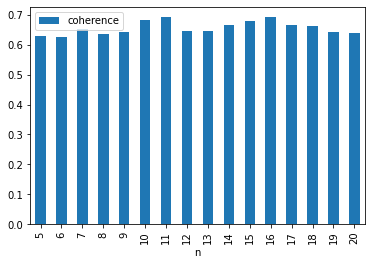

In [23]:
pd.DataFrame(coh, columns=["n", "coherence"]).set_index("n").plot.bar()

Die Scores sind insgesamt niedriger, was der Wahrnehmung entspricht. Die LDA-Topics sind schlechter zu interpretieren. Schau dir auch hier das optimale Ergebnis an:

In [ ]:
lda = LatentDirichletAllocation(n_components=11, random_state=42)
lda.fit(cvec)
display_topics(lda, cv.get_feature_names(), 10)

## Metriken auf jeden Fall mit berücksichtigen!

Auch wenn die Intuition oder Visualisierung dir oft hilft, solltest du unbedingt wenn möglich immer Metriken berechnen, um dich von der Validität deiner Ergebnisse zu überzeugen.

Für Dimensionsreduktion, Clustering und Topic-Modelle gibt es solche Metriken. Beim überwachten Lernen werden Metriken eine fast noch wichtigere Rolle spielen.